In [6]:
import os
import json
import pandas as pd
import numpy as np
import requests
import re

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from collections import defaultdict
from sklearn.neighbors import BallTree

In [7]:
paths = [path for path in os.listdir("raw_data") if path.endswith(".pickle") and re.match("[0-9]",path)]

In [8]:
df = pd.DataFrame([pd.read_pickle("raw_data/" + path) for path in paths])

In [9]:
# Charging stations
len(df)

1972

Due to the noise of the data, some of the data points are in Germany, Sweden or others. Since we are focusing on Denmark we want to filter these out

In [10]:
df = df[-df.country_code.isin(["DE", "SE"])]

This cleared out most of them, there are still some stragglers however so we use the charging stations' adresses which are formatted nicely and therefore we can use them to identify things we do not want to include, i.e. the rest that are in charging stations that are in Germany, Sweden or El Salvador

In [11]:
print(df["address"].apply(lambda x: x.split(",")[-1].strip() if type(x) == str else "fail").unique()[:10], "...")

['Denmark' 'DK' 'Lindegårdsdalen 2 4500 Nykøbings sj' 'Danmark'
 '4990 Sakskøbing' '7330 Brande' '2200 København N'
 'Nordre Ringvej 6A 6950 Ringkøbing' '2900 Hellerup' '6920 Videbæk'] ...


In [13]:
# How many of the remaining rows are still foreign charging stations
print(len(df[df.address.str.contains("(Deutschland|DE|Sweden|Sverige|El Salvador|Germany)")]))

13


/var/folders/xc/rd97lqhs6yq7j48brsn0jf3r0000gn/T/ipykernel_22228/2737106728.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  print(len(df[df.address.str.contains("(Deutschland|DE|Sweden|Sverige|El Salvador|Germany|Ikast|Brand)")]))


In [14]:
df = df[-df.address.str.contains("(Deutschland|DE|Sweden|Sverige)")]

/var/folders/xc/rd97lqhs6yq7j48brsn0jf3r0000gn/T/ipykernel_22228/2279563797.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df = df[-df.address.str.contains("(Deutschland|DE|Sweden|Sverige)")]


In [15]:
# This has jumbled the index, so now there are gaps, we can use the id as new index
df = df.set_index("id")

In [16]:
df.head()

,latitude,longitude,address,created_at,municipality,city,zip_code,plugs,cost_description,description,country_code
id,,,,,,,,,,,
96548,55.494803,9.721409,"Teglgårdsvej 73, 5500 Middelfart, Denmark",2016-10-01T10:37:25Z,Middelfart Municipality,Middelfart,5500,2,Free,Free for hotel guests: http://www.sinatur.dk/m...,DK
347220,55.931031,12.265286,"Bragesvej 4, 3400 Hillerød, Denmark",2021-11-10T17:37:53Z,None,Hillerød,3400,8,,,DK
349538,55.360006,10.666376,"Lundsager 10, 5540 Ullerslev, Denmark",2021-11-25T14:27:35Z,None,Ullerslev,5540,4,"3,5 kr pr. kWh. MobilePay",2 stk. ladestandere med to udtag hver fra Base...,DK
293418,55.627240,12.576800,"Ørestads Boulevard 114, København S, None, DK",2021-01-05T01:22:16Z,None,København,2300,6,,,DK
292441,55.752966,12.299143,"Måløv byvej 200, Måløv, 2760, DK",2021-01-05T01:06:45Z,None,Måløv,2760,17,,,DK


We don't want to query the API more than we have to, so we take the 7 nearest neighbors (8 including self) of each charging stations to minimize the search space.

In [25]:
df.loc[:,["latitude","longitude"]]

,latitude,longitude
id,,
96548,55.494803,9.721409
347220,55.931031,12.265286
349538,55.360006,10.666376
293418,55.627240,12.576800
292441,55.752966,12.299143
...,...,...
347485,56.154367,10.208775
88915,55.687290,12.523956
125243,57.486636,10.337960


In [50]:
distances, knn = BallTree(df.loc[:,["latitude","longitude"]]).query(df.loc[:,["latitude","longitude"]], 8)

In [51]:
with open("API_KEY", "r") as file:
    auth = file.readline().strip()

In [52]:
#test = requests.get(f"https://router.hereapi.com/v8/routes?apiKey={auth}&transportMode=car&origin=52.5308,13.3847&destination=52.5323,13.3789&return=summary")

In [53]:
if "meters.pickle" in os.listdir() and "backup.pickle" in os.listdir():
    meters = pd.read_pickle("meters.pickle")
    backup = pd.read_pickle("backup.pickle")
else:
    meters = defaultdict() # placeholder list to put to df
    backup = defaultdict(list) # backup of all the requests
    for i, neighbors_of_point in enumerate(knn):
        spot = df.iloc[neighbors_of_point[0]].name
        orig_lat = df.iloc[neighbors_of_point[0]].latitude
        orig_lon = df.iloc[neighbors_of_point[0]].longitude
        meters[spot] = 1000000000
        for neighbor in neighbors_of_point[1:]:
            dest_lat = df.iloc[neighbor,:].latitude
            dest_lon = df.iloc[neighbor,:].longitude
            query = requests.get(f"https://router.hereapi.com/v8/routes?apiKey={auth}&transportMode=car&origin={orig_lat},{orig_lon}&destination={dest_lat},{dest_lon}&return=travelSummary")
            response = query.json()
            backup[spot].append(response)
            meter = response["routes"][0]["sections"][0]["travelSummary"]["length"]
            if meters[spot] > meter:
                meters[spot] = meter
        if len(backup) % 200 == 0:
            print(f"{len(backup)} responses done...")

200 responses done...
400 responses done...
600 responses done...
800 responses done...
1000 responses done...
1200 responses done...
1400 responses done...
1600 responses done...
1800 responses done...


In [118]:
# Above cell wasn't able to find all of them, could be due timing out or other issues
# after executing is was only about 5 of them that it was unable to find, so we can find them by hand here
index = 249380 #insert unfound
del backup[index]
meters[index] = 1000000000
for i in knn[df.index.get_loc(index),1:]:
    dest_lat = df.iloc[i,:].latitude
    dest_lon = df.iloc[i,:].longitude
    hmm = requests.get(f"https://router.hereapi.com/v8/routes?apiKey={auth}&transportMode=car&origin={df.loc[309577,:].latitude},{df.loc[309577,:].longitude}&destination={dest_lat},{dest_lon}&return=travelSummary")
    response = hmm.json()
    backup[index].append(response)
    meter = response["routes"][0]["sections"][0]["travelSummary"]["length"]
    if meters[index] > meter:
        meters[index] = meter

In [120]:
# If one in meters is empty it will show up here
df.loc[df.index.isin([idx for idx in df.index if idx not in meters])].index

Int64Index([], dtype='int64', name='id')

In [122]:
for NA in [idx for idx in df.index if idx not in meters]:
    meters[NA] = None

In [635]:
df["closest_in_meters"] = pd.Series(meters, name="closest_in_meters")

In [140]:
# Get addresses of geocodes with revgeocode search
rev_coord = lambda x: requests.get(
    f"https://revgeocode.search.hereapi.com/v1/revgeocode?at={x.latitude},{x.longitude}&apiKey={auth}"
).json()
reversed_coord = df.loc[:,["latitude", "longitude"]].apply(rev_coord, axis = 1)

In [142]:
# county list to sanity check
municipalities = ["København","Aarhus","Aalborg","Odense","Vejle","Esbjerg","Frederiksberg","Randers","Viborg","Silkeborg","Kolding","Horsens","Herning","Roskilde","Næstved","Slagelse","Gentofte","Sønderborg","Holbæk","Gladsaxe","Hjørring","Skanderborg","Helsingør","Køge","Guldborgsund","Frederikshavn","Holstebro","Svendborg","Aabenraa","Rudersdal","Lyngby-Taarbæk","Ringkøbing-Skjern","Haderslev","Hvidovre","Høje Taastrup","Faaborg-Midtfyn","Hillerød","Fredericia","Greve","Varde","Ballerup","Kalundborg","Favrskov","Hedensted","Frederikssund","Skive","Vordingborg","Egedal","Syddjurs","Thisted","Vejen","Tårnby","Mariagerfjord","Ikast-Brande","Rødovre","Furesø","Fredensborg","Gribskov","Assens","Lolland","Bornholm", "Middelfart","Jammerbugt","Tønder","Norddjurs","Faxe","Vesthimmerlands","Brønderslev","Brøndby","Ringsted","Odsherred","Nyborg","Halsnæs","Rebild","Sorø","Nordfyns","Herlev","Lejre","Albertslund","Billund","Allerød","Hørsholm","Kerteminde","Solrød","Odder","Ishøj","Stevns","Glostrup","Struer","Morsø","Lemvig","Vallensbæk","Dragør","Langeland","Ærø","Samsø","Fanø","Læsø"]

In [143]:
def get_counties(reversed_coord):
    county = reversed_coord["items"][0]["address"]["county"]
    if county == "Lyngby Tårbæk":
        county = "Lyngby-Taarbæk"
    if county in municipalities:
        return county
    else:
        print(county)
        raise ValueError("Oops")

In [144]:
df["municipality"] = reversed_coord.apply(get_counties)

In [146]:
df["year"] = pd.to_datetime(df.created_at).dt.year

In [147]:
# Some of the addresses from Plugshare were badly defined, here.api has more precise addresses, we augment the data here
for key, x in df.address.items():
    if len(x.split(",")) < 2:
        df.loc[key, "address"] = reversed_coord[key]["items"][0]["address"]["label"]

In [149]:
columns = list(df)
columns = columns[:3] + columns[-1:] + columns[3:-1]
df = df[columns]

In [636]:
df.to_pickle("standers.pickle")

## Visualization

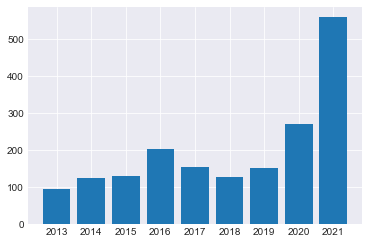

In [637]:
by_year = df.groupby("year").size()
plt.bar(by_year.keys(), by_year.values)
plt.xticks(ticks=by_year.keys(), labels=by_year.keys())
plt.show()

/var/folders/xc/rd97lqhs6yq7j48brsn0jf3r0000gn/T/ipykernel_22228/2365229613.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


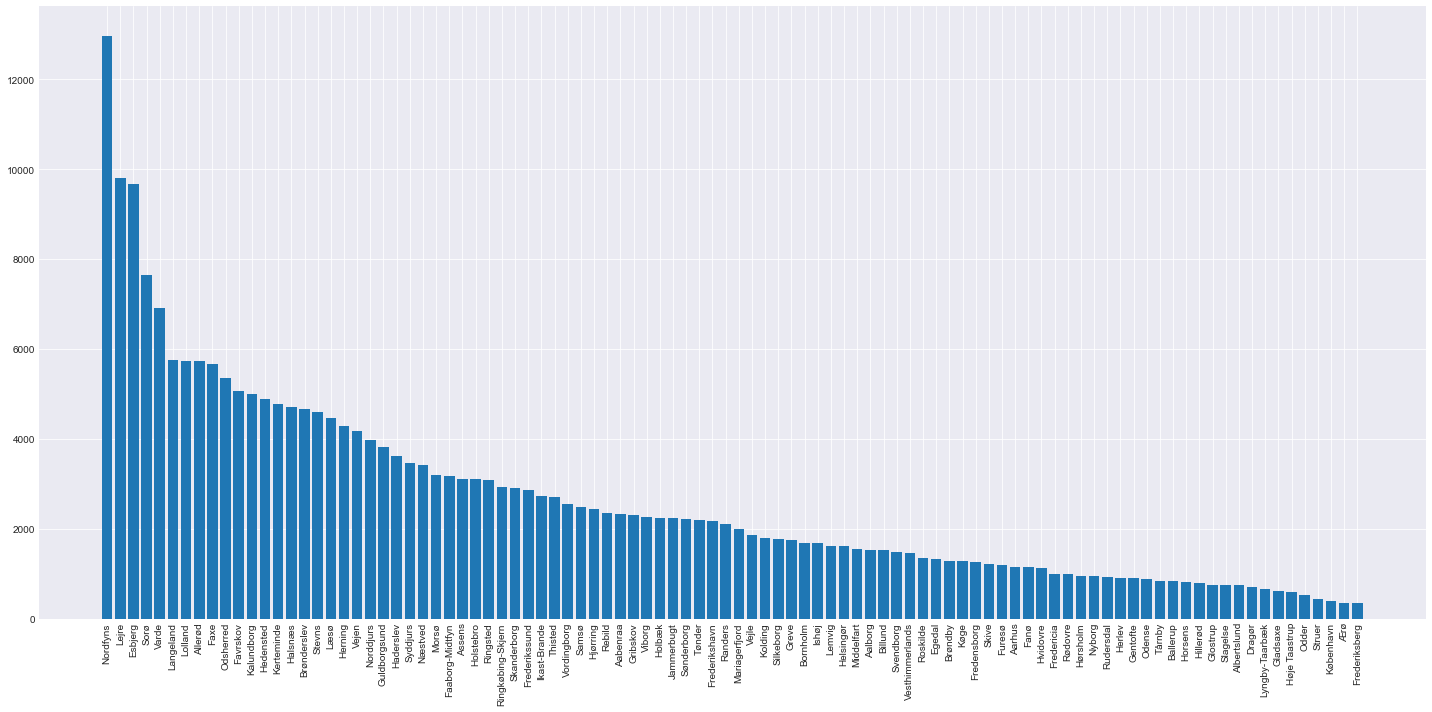

In [638]:
avg_closest = df.groupby("municipality").mean()["closest_in_meters"].sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (20,10))
ax.bar(avg_closest.keys(), avg_closest.values)
ax.set_xticks(ticks=range(len(avg_closest.keys())))
ax.set_xticklabels(labels=avg_closest.keys(), rotation=90)
plt.tight_layout()
fig.show()

In [639]:
years_looked = []
indices_year = pd.DataFrame(columns = ["up_until_year", "count_of_stations", "plugs", "closest_in_meters"])
for year in sorted(df.year.unique()):
    years_looked.append(year)
    cum_indices = df.year.isin(years_looked)
    
    relevant_columns = df.loc[cum_indices,["municipality","plugs", "closest_in_meters"]]

    size = relevant_columns.groupby("municipality").size() 
    relevant_columns["closest_in_meters"][relevant_columns.municipality.isin(size[size == 1].index)] = np.nan
    relevant_columns["count_of_stations"] = 0
    relevant_columns["closest_in_meters_std"] = relevant_columns["closest_in_meters"]
    relevant_columns = relevant_columns.groupby("municipality").aggregate(
        {
            "count_of_stations":"size", 
            "plugs":"sum", 
            "closest_in_meters": lambda x: x.mean(skipna=False), 
            "closest_in_meters_std": "std"
        }
    )
    relevant_columns["up_until_year"] = year
    indices_year = indices_year.append(relevant_columns)
indices_year = indices_year.reset_index().rename({"index":"municipality"}, axis=1)

/var/folders/xc/rd97lqhs6yq7j48brsn0jf3r0000gn/T/ipykernel_22228/3888197459.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_columns["closest_in_meters"][relevant_columns.municipality.isin(size[size == 1].index)] = np.nan


In [604]:
indices_year.to_csv("muni_aggr_charging_data.csv")

In [606]:
df.to_csv("charging_stations.csv")

In [581]:
#labels = indices_year.municipality.unique()
#x = np.arange(len(labels))  # the label locations

#width = 0.35  # the width of the bars

#fig, ax = plt.subplots(figsize=(50,10))

#year_x = {}
#rects_year = {}
#unique_years = indices_year.up_until_year.unique()
#for year in unique_years:
#    year_x[year] = indices_year[indices_year.up_until_year == year]
#    
#    x = np.arange(len(year_x[year]))
#    x_pos = x-width+width*(year/len(unique_years))
#    print(x_pos)
#    rects_year[year] = ax.bar(x_pos, year_x[year].closest_in_meters, width, label=year)

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Closest chargin station in meters')
#ax.set_title('Scores by group and gender')
#ax.set_xticks(x, labels, rotation=90)
#ax.legend()
#fig.savefig("ha")

## Verification

In [158]:
# Geo measurement function which can be used as a sanity check
def measure(lat_lon_1, lat_lon_2): 
    lat1, lon1 = lat_lon_1
    lat2, lon2 = lat_lon_2
    R = 6378.137
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 1000

In [159]:
# to be used something like this
f"{df.iloc[0].address} is {measure(df.iloc[0].values[:2], df.iloc[1378].values[:2]):.2f} meters from {df.iloc[1378].address} - coordinately"

'Teglgårdsvej 73, 5500 Middelfart, Denmark is 1301.54 meters from Søndergade 63-67, Middelfart, 5500, DK - coordinately'

In [160]:
differences = []
for key,value in backup.items():
    found_depart = value[0]["routes"][0]["sections"][0]["departure"]["place"]["location"].values()
    orig_depart = value[0]["routes"][0]["sections"][0]["departure"]["place"]["originalLocation"].values()
    differences.append(measure(found_depart, orig_depart))
    for neighbor in value:
        if "originalLocation" in neighbor["routes"][0]["sections"][0]["arrival"]["place"]:
            found_arriv = neighbor["routes"][0]["sections"][0]["arrival"]["place"]["location"].values()
            orig_arriv = neighbor["routes"][0]["sections"][0]["arrival"]["place"]["originalLocation"].values()
            differences.append(measure(found_arriv, orig_arriv))
        else:
            differences.append(0)

In [165]:
print(f"There is an estimated {np.mean(differences):.2f}m of movement from where the HERE API have data to where the lon and lat of our data lies")

There is an estimated 16.37m of movement from where the HERE API have data to where the lon and lat of our data lies
